### Learning, Information and Knowledge Systems Lab, SEAS, Harvard University
### Hsiang Hsu
#### hsianghsu@g.harvard.edu

# Classifier Inversion Problem

**Fall 2017**<br/>
**Instructors**: Professor Flavio Calmon

---

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Testing MNIST Dataset

I use the sample codes in https://www.tensorflow.org/get_started/mnist/beginners to get familiar with MNIST and tenrsorflow package.

In [2]:
#import the mnist data
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#a custom to import tensorflow as tf
#import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

# Training
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# Evaluating
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Tensor("Placeholder_3:0", shape=(?, 784), dtype=float32)
0.9207


## Testing MNIST DNN

I use the sample codes in https://www.tensorflow.org/get_started/mnist/pros to get familiar with MNIST and tenrsorflow package. The DNN is constructed by using ***convolutional*** neurons and ***ReLU*** activation functions.

In [2]:
sess = tf.InteractiveSession()
'''
# A softmax regression model
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.global_variables_initializer())

y = tf.matmul(x,W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
'''
# Multilayer Convolutional Networks
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
# First layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to avoid overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and evalute the models
# Input: y_conv, y_
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.04


KeyboardInterrupt: 

## Plot MNIST handwritting figures

In [46]:
def draw_mnist(n):
    image_arr = mnist.train.images[n]
    label_arr = mnist.train.labels[n]
    label = np.where(label_arr==1)[0][0]
    image = np.reshape(image_arr, (28, 28))
    plt.imshow(image, cmap='gray')
    plt.title('%s'%label)
    plt.show()

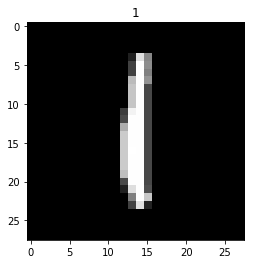

In [47]:
#print mnist.train.images[1]

draw_mnist(1000)

## Plot noisy data

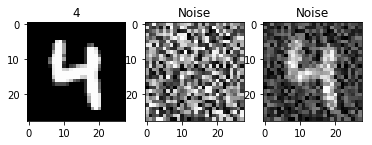

In [41]:
n = 1
image_arr = mnist.train.images[n]
label_arr = mnist.train.labels[n]
label = np.where(label_arr==1)[0]
image = np.reshape(image_arr, (28, 28))

f, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap='gray');
ax[0].set_title('%s'%label[0]);

noise = np.random.rand(28, 28)
ax[1].imshow(noise, cmap='gray');
ax[1].set_title('Noise');

ax[2].imshow(np.add(image, noise), cmap='gray');
ax[2].set_title('Noise');

## Test on extracting prediction results

In [40]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Multilayer Convolutional Networks
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


# First layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to avoid overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and evalute the models
# Input: y_conv, y_
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(y_conv,1)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Start the interactive session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(200):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, has used %d samples, training accuracy %g' % (i, 50*i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    #print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    number = prediction.eval(feed_dict={x: mnist.test.images[0:2], keep_prob: 1.0})[0]
    
print(number)

step 0, has used 0 samples, training accuracy 0.08
step 100, has used 5000 samples, training accuracy 0.82
7


## Test on sci.optimization BFGS

In [45]:
from scipy.optimize import minimize

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
y0 = 10

def rosen(x, y):
    return sum(y*100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

print('BFGS optimization without gradient information')
res = minimize(rosen, x0, y0, method='BFGS', options={'disp': True})
print(res.x)

BFGS optimization without gradient information
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 901
         Gradient evaluations: 127
[ 0.99999213  0.99998425  0.99996854  0.99993708  0.99987415]


## Test on generating MNIST data

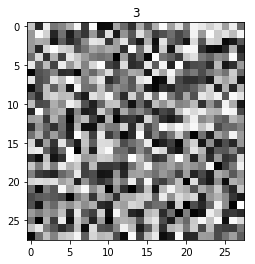

In [9]:
generate_random_matrix = np.random.rand(28, 28)
#print(type(generate_random_matrix))
plt.imshow(generate_random_matrix, cmap='gray')
plt.title('%s'%label[0])
plt.show()

## Test on constraints

In [8]:
noise = np.random.rand(1, 28*28)
const = (noise >= 0) & (noise <= 1)
satisty = np.sum( const[0] ) - 28*28
print(satisty)

0


## Test to train random image

step 100, has used 2000 samples, training accuracy 0.9
step 200, has used 4000 samples, training accuracy 0.9
step 300, has used 6000 samples, training accuracy 1
step 400, has used 8000 samples, training accuracy 0.9
step 500, has used 10000 samples, training accuracy 0.9
test accuracy 0.9258
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: -516.1036644632587
            Iterations: 1
            Function evaluations: 786
            Gradient evaluations: 1
The Frobenius norm of the perturbation is 16.103664


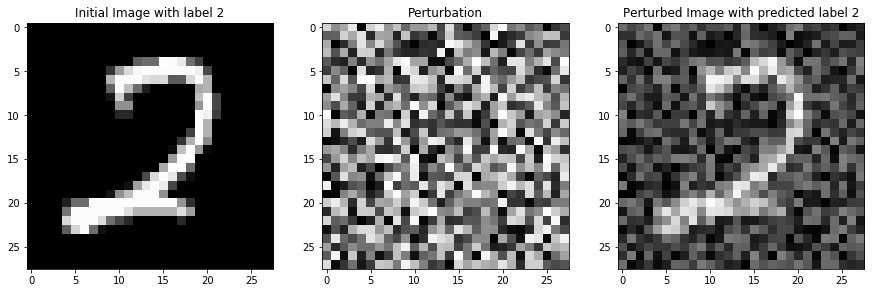

In [40]:
# train the DNN
from scipy.optimize import minimize

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
initial_image_index = np.random.randint(0, 5000-1)
scalarization_parameter = 500

# Multilayer Convolutional Networks
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


# First layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to avoid overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and evalute the models
# Input: y_conv, y_
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(y_conv,1)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

''' Defining loss function '''
def loss(l_1, l_2):
    #return np.log(1 + np.exp(-abs(l_1-l_2)))/np.log(2)
    return (-1) * ( np.log(1 + np.exp(-abs(l_1-l_2)))/np.log(2) )
'''

def objective(r, c, x, l):
    return (-1)*LA.norm(r, ord=None) + c*loss(l, prediction.eval(feed_dict={x: mnist.test.images[0:2], keep_prob: 1.0}))

def objective(r, c, x, l_1):
    return (-1)*LA.norm(r, ord=None) + c*loss(l_1, prediction.eval(feed_dict={x: np.add(x, r), keep_prob: 1.0})[0])
'''


# Start the interactive session
with tf.Session() as sess:
    ''' Training the classifier '''
    batch_size = 20
    training_times = 500
    sess.run(tf.global_variables_initializer())
    for i in range(training_times):
        batch = mnist.train.next_batch(batch_size)
        if (i+1) % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, has used %d samples, training accuracy %g' % ((i+1), batch_size*(i+1), train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ''' Plot initial image '''
    initial_image = mnist.test.images[initial_image_index]
    initial_label_arr = mnist.test.labels[initial_image_index]
    initial_label = np.where(initial_label_arr==1)[0][0]
    image = np.reshape(initial_image, (28, 28))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Initial Image with label %s'%initial_label)
    
    ''' Define functions for optimization '''
    def objective(r):
        return (-1)*np.linalg.norm(r, ord=None) + scalarization_parameter * \
                loss(initial_label, prediction.eval(feed_dict={x: np.reshape(np.add(initial_image, r), (1, 784)), keep_prob: 1.0})[0])
        
    def constrain(r):
        add_image = np.add(initial_image, r)
        const = (add_image >= 0) & (add_image <= 1)
        return np.sum( const[0] ) - 28*28
    
    cons = {'type':'eq', 'fun': constrain}
    
    ''' Running BFGS-L algorithm '''
    # Methods L-BFGS-B and BFGS are not supported with constraints
    # Method COBYLA is not supported with constrains in 'eq' type 
    initial_noise = np.random.rand(1, 784)
    perturb = minimize(objective, initial_noise, method='SLSQP', options={'maxiter': 50, 'disp': True}, constraints = cons)
    
    perturbation = np.reshape(perturb.x, (28, 28))
    ax[1].imshow(perturbation, cmap='gray')
    ax[1].set_title('Perturbation')
    
    new_image = np.add(initial_image, perturb.x)
    new_label = prediction.eval(feed_dict={x: np.reshape(new_image, (1, 784)), keep_prob: 1.0})[0]
    ax[2].imshow(np.reshape(new_image, (28, 28)), cmap='gray')
    ax[2].set_title('Perturbed Image with predicted label %s'%new_label)
    
    print('The Frobenius norm of the perturbation is %f' %np.linalg.norm(perturb.x, ord=None))
    
    
    
    #test_image = np.random.rand(1, 784)
    #print(type(mnist.test.images[0:1]))
    '''
    def objective(r, c, x, l_1):
        return (-1)*LA.norm(r, ord=None) + c*loss(l_1, prediction.eval(feed_dict={x: np.add(x, r), keep_prob: 1.0})[0])
    '''
    #g = lambda image: prediction.eval(feed_dict={x: image, keep_prob: 1.0})
    
    #number = prediction.eval(feed_dict={x: test_image, keep_prob: 1.0})
    
    #image = np.reshape(test_image, (28, 28))
    #plt.imshow(image, cmap='gray')
    #plt.show()
    
    
#print(g(np.random.rand(1, 784)))   
#print(number, number[0])

In [33]:
print(perturb.x)

[ 0.64660555  0.36747276  0.42611279  0.31758295  0.11263094  0.59414154
  0.13298035  0.91021125  0.15671657  0.55402752  0.51206256  0.96468436
  0.71257996  0.69883596  0.70097881  0.43334909  0.30537086  0.85288371
  0.84321281  0.77984594  0.17518674  0.30858518  0.96333284  0.12391091
  0.04466358  0.88714543  0.70577525  0.81432018  0.95445308  0.34532148
  0.01571567  0.31710627  0.39905929  0.74315951  0.64732248  0.29669167
  0.69624094  0.91923109  0.76255398  0.43469965  0.14498762  0.5835303
  0.90487765  0.51293481  0.09324051  0.98693989  0.28435366  0.66509795
  0.73247183  0.00422529  0.74777147  0.35918492  0.91787994  0.20883013
  0.89969855  0.75860124  0.81928668  0.16314416  0.53586321  0.94712145
  0.23525742  0.06707258  0.9062958   0.23853652  0.23845064  0.29206587
  0.80544472  0.05196769  0.8392696   0.32945862  0.5096028   0.41266549
  0.89967613  0.28586684  0.76065427  0.67412264  0.86061322  0.4946744
  0.42874002  0.95874062  0.12942276  0.43195984  0.8

# =======================================================

## Classifier inversion

In [53]:
# import data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# import packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import linalg as LA
from scipy.optimize import minimize

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [36]:
# Defining loss function
def loss(l_1, l_2):
    #return np.log(1 + np.exp(-abs(l_1-l_2)))/np.log(2)
    return (-1) * np.log(1 + np.exp(-abs(l_1-l_2)))/np.log(2) 
# Defining the objective function 
'''
### have problems
'''
def objective(r, c, x, l_1):
    return (-1)*LA.norm(r, ord=None) + c*loss(l_1, l_2)

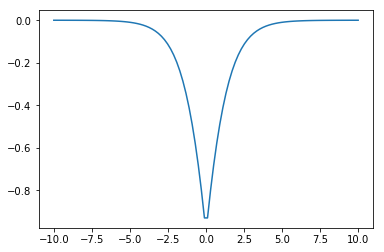

In [37]:
x = np.linspace(-10, 10, 100)
y = 0

plt.plot(x, loss(x, y))
plt.show()

step 100, has used 2000 samples, training accuracy 0.65
step 200, has used 4000 samples, training accuracy 1
step 300, has used 6000 samples, training accuracy 0.9
step 400, has used 8000 samples, training accuracy 0.95
step 500, has used 10000 samples, training accuracy 1
test accuracy 0.9261
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: -516.3556382139058
            Iterations: 1
            Function evaluations: 786
            Gradient evaluations: 1
The Frobenius norm of the perturbation is 16.355638


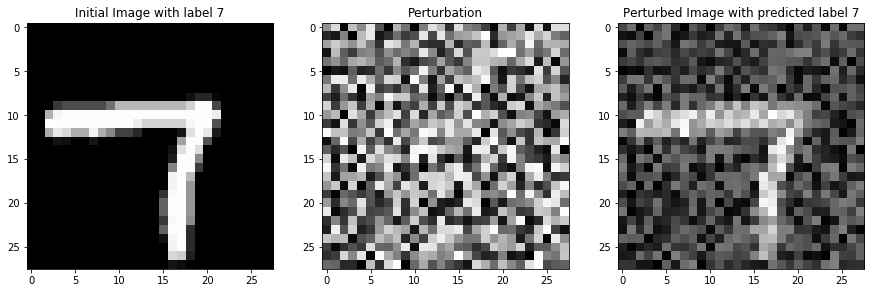

In [3]:
# train the DNN
from scipy.optimize import minimize

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
initial_image_index = np.random.randint(0, 5000-1)
scalarization_parameter = 500

# Multilayer Convolutional Networks
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


# First layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout to avoid overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Train and evalute the models
# Input: y_conv, y_
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
prediction = tf.argmax(y_conv,1)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

''' Defining loss function '''
def loss(l_1, l_2):
    #return np.log(1 + np.exp(-abs(l_1-l_2)))/np.log(2)
    return (-1) * ( np.log(1 + np.exp(-abs(l_1-l_2)))/np.log(2) )


# Start the interactive session
with tf.Session() as sess:
    ''' Training the classifier '''
    batch_size = 20
    training_times = 500
    sess.run(tf.global_variables_initializer())
    for i in range(training_times):
        batch = mnist.train.next_batch(batch_size)
        if (i+1) % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, has used %d samples, training accuracy %g' % ((i+1), batch_size*(i+1), train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ''' Plot initial image '''
    initial_image = mnist.test.images[initial_image_index]
    initial_label_arr = mnist.test.labels[initial_image_index]
    initial_label = np.where(initial_label_arr==1)[0][0]
    image = np.reshape(initial_image, (28, 28))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Initial Image with label %s'%initial_label)
    
    ''' Define functions for optimization '''
    def objective(r):
        return (-1)*np.linalg.norm(r, ord=None) + scalarization_parameter * \
                loss(initial_label, prediction.eval(feed_dict={x: np.reshape(np.add(initial_image, r), (1, 784)), keep_prob: 1.0})[0])
        
    def constrain(r):
        add_image = np.add(initial_image, r)
        const = (add_image >= 0) & (add_image <= 1)
        return np.sum( const[0] ) - 28*28
    
    cons = {'type':'eq', 'fun': constrain}
    
    ''' Running BFGS-L algorithm '''
    # Methods L-BFGS-B and BFGS are not supported with constraints
    # Method COBYLA is not supported with constrains in 'eq' type 
    initial_noise = np.random.rand(1, 784)
    perturb = minimize(objective, initial_noise, method='SLSQP', options={'maxiter': 50, 'disp': True}, constraints = cons)
    
    perturbation = np.reshape(perturb.x, (28, 28))
    ax[1].imshow(perturbation, cmap='gray')
    ax[1].set_title('Perturbation')
    
    new_image = np.add(initial_image, perturb.x)
    new_label = prediction.eval(feed_dict={x: np.reshape(new_image, (1, 784)), keep_prob: 1.0})[0]
    ax[2].imshow(np.reshape(new_image, (28, 28)), cmap='gray')
    ax[2].set_title('Perturbed Image with predicted label %s'%new_label)
    
    print('The Frobenius norm of the perturbation is %f' %np.linalg.norm(perturb.x, ord=None))